# Compute FWHM of PSTHs for 11 and 30Hz

Only PSTHs with a significance level below 0.05 are used

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import expipe
import os
import pathlib
import numpy as np
import exdir
import pandas as pd
import optogenetics as og
import quantities as pq
import shutil
from distutils.dir_util import copy_tree
import seaborn as sns
from functools import reduce
from septum_mec.analysis.stimulus_response import stimulus_response_latency, compute_response
import scipy.stats
from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from septum_mec.analysis.statistics import load_data_frames, make_paired_tables, make_statistics_table 
tqdm_notebook.pandas()

%matplotlib widget

In [3]:
std_gaussian_kde = 0.04
window_size = 0.05
tmin = 0. # delay to compute FWHM after stimulus onset

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [8]:
output = pathlib.Path('output/stimulus-response-fwhm-gc-inhibition')
(output / 'data').mkdir(parents=True, exist_ok=True)
(output / 'figures').mkdir(parents=True, exist_ok=True)
(output / 'statistics').mkdir(parents=True, exist_ok=True)

In [25]:
df = load_data_frames()[0]

Number of sessions above threshold 194
Number of animals 4
Number of individual gridcells 139
Number of gridcell recordings 230


In [28]:
stim_df = df.query("stimulated")
stim_df = stim_df.query("p_e_peak < 0.05")
print(len(stim_df))

222


In [29]:
psth_start = -0.01
window_size = 0.05
times = np.arange(psth_start, window_size, 1e-4)
tmin = 0.005
psths = []
fwhms = []
for i, row in tqdm(stim_df.iterrows(), total=len(stim_df)):
    action_id = row['action']
    channel_group = row['channel_group']
    unit_name = row['unit_name']
    name = f'{action_id}_{channel_group}_{unit_name}'
    spike_times = data_loader.spike_train(action_id, channel_group, unit_name)
    
    spike_times = np.array(spike_times)
    
    stim_times = data_loader.stim_times(action_id)
    
    if stim_times is None:
        continue
    
    stim_times = np.array(stim_times)
    
    _, spikes, kernel, p_e, p_i = stimulus_response_latency(
        spike_times, stim_times, window_size, std_gaussian_kde)
    
    if all(np.isnan([p_e, p_i])):
        continue
    
    psths.append(kernel(times))
    fwhm = compute_fwhm(kernel(times), times, tmin)
    fwhms.append(fwhm)

In [58]:
stim_df["psth"] = psths

In [67]:
baseline_interval = [-0.005, 0.005]
post_interval_11 = [0.015, 0.025]
post_interval_30 = [0.020, 0.030]

bl_avgs = []
post_avgs = []

for i, row in stim_df.iterrows():
    bl_idxs = np.searchsorted(times, baseline_interval, side="right")
    avg_bl = np.mean(row.psth[bl_idxs])
    if row.frequency == 11:
        post_idxs = np.searchsorted(times, post_interval_11, side="right")
    else:
        post_idxs = np.searchsorted(times, post_interval_30, side="right")
        
    avg_post = np.mean(row.psth[post_idxs])
    bl_avgs.append(avg_bl)
    post_avgs.append(avg_post)

In [70]:
stim_df["psth_avg_baseline"] = bl_avgs
stim_df["psth_avg_post"] = post_avgs

In [48]:
columns = ["psth_avg_baseline", "psth_avg_post"]
results, labels = make_paired_tables(stim_df, columns)

In [53]:
stat, _ = make_statistics_table(results["gridcell"], labels)

In [54]:
stat

,Psth avg baseline,Psth avg post
Baseline I,NaN,NaN
Normality Baseline I,NaN,NaN
11 Hz,1.8e+01 ± 1.1e+00 (23),6.5e+00 ± 6.0e-01 (23)
Normality 11 Hz,"2.5e+00, 2.8e-01","5.7e-01, 7.5e-01"
Baseline II,NaN,NaN
Normality Baseline II,NaN,NaN
30 Hz,8.0e+00 ± 4.3e-01 (21),9.6e+00 ± 5.7e-01 (21)
Normality 30 Hz,"3.6e+00, 1.6e-01","7.7e-01, 6.8e-01"
Wilcoxon Baseline I - 11 Hz,NaN,NaN
LMM Baseline I - 11 Hz,NaN,"7.8e-01 [-8.5e-01, 1.1e+00]"


In [ ]:
def violinplot2(data, xticks, colors):
    pos = [i * 0.6 for i in range(len(data))]
    print(pos)
    violins = plt.violinplot(data, pos, showmeans=True, showextrema=False)
    
    for i, b in enumerate(violins['bodies']):
        b.set_color(colors[i])
        b.set_alpha (0.8)

 

    # for i, body in enumerate(violins['cbars']):
    #     body.set_color('C{}'.format(i))

 

    for category in ['cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans']:
        if category in violins:
            violins[category].set_color(['k', 'k'])
            violins[category].set_linewidth(2.0)
    plt.xticks(pos, xticks, rotation=45)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[0.0, 0.6]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[0.0, 0.6]


Text(0.5, 1.0, '30Hz')

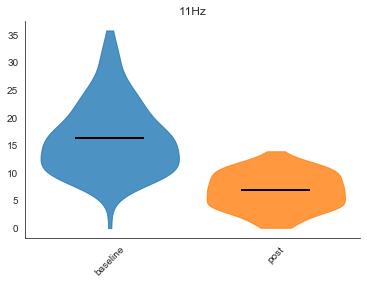

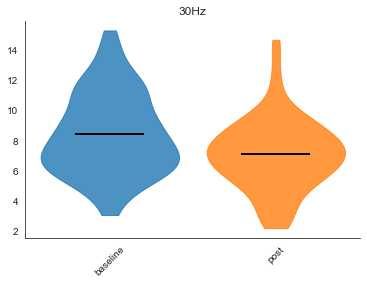

In [72]:
stim11 = stim_df.query("frequency == 11")
stim30 = stim_df.query("frequency == 30")

fig = plt.figure()
violinplot2(
    [stim11.psth_avg_baseline, stim11.psth_avg_post], 
    colors=["C0", "C1"],
    xticks=["baseline", "post"],
)
plt.title("11Hz")

fig = plt.figure()
violinplot2(
    [stim30.psth_avg_baseline, stim30.psth_avg_post], 
    colors=["C0", "C1"],
    xticks=["baseline", "post"],
)
plt.title("30Hz")

In [ ]:
# 11
fig = plt.figure()
violinplot2(
    [session_units_sig_11.fwhm.dropna().values, session_units_sig_30.fwhm.dropna().values], 
    colors=colors,
    xticks=["11 Hz  ", "  30 Hz"],
)
figname = 'stim-response-fwhm-11-30Hz'
fig.savefig(
    output / 'figures' / f'{figname}.png', 
    bbox_inches='tight', transparent=True)
fig.savefig(
    output / 'figures' / f'{figname}.svg', 
    bbox_inches='tight', transparent=True)

# Save to expipe

In [ ]:
action = project.require_action("stimulus-response-fwhm")

In [ ]:
action.modules['parameters'] = {
    'window_size': window_size,
    'std_gaussian_kde': std_gaussian_kde,
    'tmin': tmin
}

In [ ]:
action.data['results'] = 'results.csv'
session_units_sig.to_csv(action.data_path('results'), index=False)

In [ ]:
copy_tree(output_path, str(action.data_path()))

In [ ]:
septum_mec.analysis.registration.store_notebook(action, "10-calculate-stimulus-response-fwhm.ipynb")